# Machine Learning in identifying housing type using Airbnb Data

# 1: Introduction
Airbnb, as a digital platform, allows citizens to find and rent short-term accommodation from other citizens. Airbnb has the potential to change the traditional spatial relationship between tourist and local, making our cities more vibrant and diverse places to live in and to visit. This study used the characteristics of the houses in Sydney and Melbourn listed in Airbnb (until 06 October, 2018). In particular, this study will try to classify the city's postcodes into a small number of groups that will explore the patterns about the main kinds of houses and areas in the city.

# 2: Code

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import pysal as ps
from sklearn import cluster
from sklearn.preprocessing import scale

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
# Download detailed listing from 'http://insideairbnb.com/get-the-data.html', then read the file. The file contains a lot of information
# about each individual location listed at AirBnb within Greater Sydney and Greater Melbourn
Syd_listings_link = 'data/listings_Syd.csv.gz'
Mel_listings_link = 'data/listings_Mel.csv.gz'

Syd_lst = pd.read_csv(Syd_listings_link)
Mel_lst = pd.read_csv(Mel_listings_link)
Syd_lst.info()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33430 entries, 0 to 33429
Data columns (total 96 columns):
id                                  33430 non-null int64
listing_url                         33430 non-null object
scrape_id                           33430 non-null int64
last_scraped                        33430 non-null object
name                                33417 non-null object
summary                             32705 non-null object
space                               22855 non-null object
description                         33130 non-null object
experiences_offered                 33430 non-null object
neighborhood_overview               19503 non-null object
notes                               13865 non-null object
transit                             20155 non-null object
access                              20102 non-null object
interaction                         18489 non-null object
house_rules                         19754 non-null object
thumbnail_url          

This study use bokeh to create interactive graphs, the original data (lon/lat coordinates) need to be reprojected into Web Mercator, as bokeh will expect them. To do that, coordinates are turned into a GeoSeries.

In [3]:
#For Sydney data
from shapely.geometry import Point
xys_wbs = gpd.GeoSeries(Syd_lst[['longitude', 'latitude']].apply(Point, axis=1), crs="+init=epsg:4326")
xys_wbs = xys_wbs.to_crs(epsg=3857)
x_wbs = xys_wbs.apply(lambda i: i.x)
y_wbs = xys_wbs.apply(lambda i: i.y)

In [4]:
#For Melbourn data
xys_wbm = gpd.GeoSeries(Mel_lst[['longitude', 'latitude']].apply(Point, axis=1), \
                      crs="+init=epsg:4326")
xys_wbm = xys_wbm.to_crs(epsg=3857)
x_wbm = xys_wbm.apply(lambda i: i.x)
y_wbm = xys_wbm.apply(lambda i: i.y)

In [5]:
#Set up the plot in Bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN
output_notebook()

minx, miny, maxx, maxy = xys_wbs.total_bounds
y_ranges = miny, maxy
x_ranges = minx, maxx

def base_plot_s(tools='pan,wheel_zoom,reset',plot_width=600, plot_height=400, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_ranges, y_range=y_ranges, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

options = dict(line_color=None, fill_color='#800080', size=4)

Loading BokehJS ...

In [6]:
#Plot the data with terrain.
ps = base_plot_s()
ps.add_tile(STAMEN_TERRAIN)
ps.circle(x=x_wbs, y=y_wbs, **options)
show(ps)

In [7]:
#Then do the same for Melbourn
minxm, minym, maxxm, maxym = xys_wbm.total_bounds
y_rangem = minym, maxym
x_rangem = minxm, maxxm

def base_plot_m(tools='pan,wheel_zoom,reset',plot_width=600, plot_height=400, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_rangem, y_range=y_rangem, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

options = dict(line_color=None, fill_color='#800080', size=4)

In [8]:
pm = base_plot_m()
pm.add_tile(STAMEN_TERRAIN)
pm.circle(x=x_wbm, y=y_wbm, **options)
show(pm)

Data on Airbnb accommodation in Melbourne and Sydney as of 06 October 2018 are:
Melbourne: 21,521 listings, of which 57% are for entire homes
Sydney: 33,430 listings, of which 61% are for entire homes.

As the graph and data shows, when the number of points grows, at some point, it becomes impossible to discern anything other than a big blur of color. To some extent, interactivity gets at that problem by allowing the user to zoom in until every point is an entity on its own. However, there exist techniques that allow to summarize the data to be able to capture the overall pattern at once. Traditionally, kernel density estimation (KDE) has been one of the most common solutions by approximating a continuous surface of point intensity. In this study, however, the datashader library are introduced in the study to visualise the data by using KDE.

In [9]:
# Datashader only accept dataframe to calculate KDE, so first thing is to convert data to a pandas dataframe, then plot the data.
# The following two graph using different background to demonstrate the detail of KDE visualisation.
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, inferno

background = "black"
cm = partial(colormap_select, reverse=(background=="black"))
#For Sydney data
ptss = pd.DataFrame({'x': x_wbs, 'y': y_wbs})
ptss['count'] = 1

def create_image90(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(ptss, 'x', 'y',  ds.count('count'))
    img = tf.shade(agg.where(agg > np.percentile(agg,90)), \
                         cmap=inferno, how='eq_hist')
    return tf.dynspread(img, threshold=0.1, max_px=4)

ps = base_plot_s(background_fill_color=background)
#s.add_tile(STAMEN_TERRAIN)
InteractiveImage(ps,create_image90)

In [10]:
#For Melbourn data
ptsm = pd.DataFrame({'x': x_wbm, 'y': y_wbm})
ptsm['count'] = 1

def create_image90(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(ptsm, 'x', 'y',  ds.count('count'))
    img = tf.shade(agg.where(agg > np.percentile(agg,90)), \
                         cmap=inferno, how='eq_hist')
    return tf.dynspread(img, threshold=0.1, max_px=4)

pm = base_plot_m(background_fill_color=background)
pm.add_tile(STAMEN_TERRAIN)
InteractiveImage(pm,create_image90)

The most of listings in Melbourne is around the CBD, one of the reasion is that the boom in high-density development in the CBD has resulted in an excess of homogeneous apartment dwellings. Bedrooms without natural light, as well as insufficient floor area, outdoor space and storage space, characterise many of these developments, rendering them effectively unlivable for long-term residents(Alexander, 2016). But these properties are attractive to itinerant tenants seeking affordable inner city accommodation.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


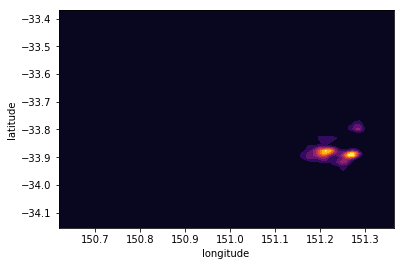

In [11]:
# Single KDE plotted on map.(Sydney)
sns.kdeplot(Syd_lst['longitude'], Syd_lst['latitude'], shade=True, cmap='inferno');

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


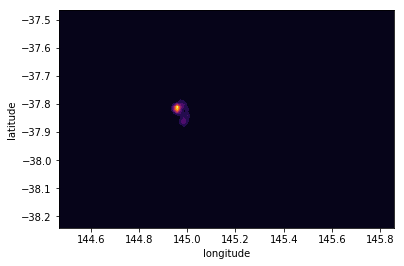

In [12]:
# Single KDE plotted on map.(Melbourn)
sns.kdeplot(Mel_lst['longitude'], Mel_lst['latitude'], shade=True, cmap='inferno');

These KDE map shows that the patterns of Airbnb listings in Australia’s biggest cities are highly uneven. The graphs suggest the impacts on rental housing are likely to be biggest in high-end areas that appeal to tourists. Other areas are less affected. Airbnb listings aggregate around the city centre but also extend beyond the inner core to the suburban residential area. However, the composition of listings has less effect on their distribution in Melbourne than in Sydney(Alizadeh, 2018).

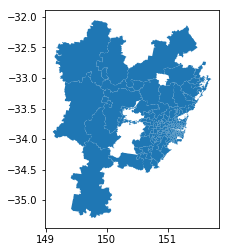

In [13]:
# Load postcode and boundaries for Sydney 
pcs = gpd.read_file('data/GS_postcode.json')
pcs.plot();

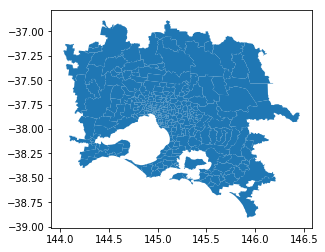

In [14]:
# Load postcode and boundaries for Melbourn 
pcm = gpd.read_file('data/GM_postcode.json')
pcm.plot();

In [15]:
# Set seaborn style into whitegrid.
sns.set(style="whitegrid")

# 3: Sydney Clustering

In [16]:
#Originally, this dataset was provided at the individual level. Since we will be working in terms of postcode areas, 
#data need to be aggregated to the region level. 
varis = ['bedrooms', 'bathrooms', 'beds']

#All of the variables are numerical values, so a quick way to aggregate them is by obtaining the average per postcode.
aves = Syd_lst.groupby('zipcode')[varis].mean()
aves.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 1711.0 to NSW 2025
Data columns (total 3 columns):
bedrooms     452 non-null float64
bathrooms    452 non-null float64
beds         452 non-null float64
dtypes: float64(3)
memory usage: 14.1+ KB


In [17]:
# In addition to these variables, proportions of different types of houses in each postcode area need to be included. 
# The proportion of different types indicates which area have the most high-density housing than other areas.

types = pd.get_dummies(Syd_lst['property_type'])
prop_types = types.join(Syd_lst['zipcode']).groupby('zipcode').sum()
prop_types_pct = (prop_types * 100.).div(prop_types.sum(axis=1), axis=0)
prop_types_pct.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 1711.0 to NSW 2025
Data columns (total 39 columns):
Aparthotel                452 non-null float64
Apartment                 452 non-null float64
Barn                      452 non-null float64
Bed and breakfast         452 non-null float64
Boat                      452 non-null float64
Boutique hotel            452 non-null float64
Bungalow                  452 non-null float64
Bus                       452 non-null float64
Cabin                     452 non-null float64
Camper/RV                 452 non-null float64
Campsite                  452 non-null float64
Casa particular (Cuba)    452 non-null float64
Castle                    452 non-null float64
Chalet                    452 non-null float64
Condominium               452 non-null float64
Cottage                   452 non-null float64
Dome house                452 non-null float64
Earth house               452 non-null float64
Farm stay                 452 non-null float

In [18]:
# Join the dataset together.
aves_props = aves.join(prop_types_pct)
# Change the columns
db = pd.DataFrame(scale(aves_props), index=aves_props.index, columns=aves_props.columns)

In [19]:
# Combines the postcode area and data.
pdb = pcs[['geometry', 'postcode']].join(db, on='postcode').dropna()

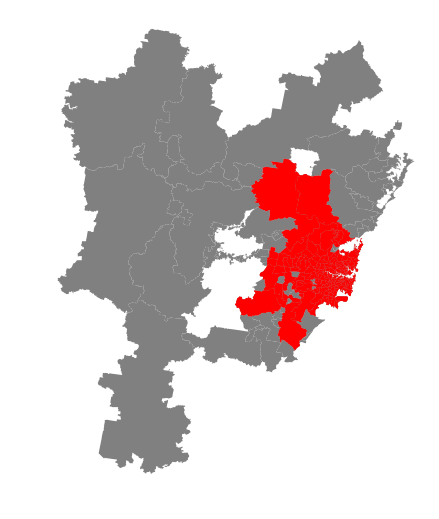

In [20]:
# Some of the area have lost in the process, plot the two area together to see the difference.
# The graph shows the most of the Airbnb listing is in eastern district.
f, ax = plt.subplots(1, figsize=(9, 9))

pcs.plot(color='grey', linewidth=0, ax=ax)
pdb.plot(color='red', linewidth=0.1, ax=ax)

ax.set_axis_off()

plt.show()

In the context of our listing type data analysis, this study group different types of listing based on the postcode position. This will provide insight into the short-term rental in Greater Sydney and Greater Melbourn.

Although there exist many techniques to statistically group observations in a dataset, all of them are based on the premise of using a set of attributes to define classes or categories of observations that are similar within each of them, but differ between groups. How similarity within groups and dissimilarity between them is defined and how the classification algorithm is operationalized is what makes techniques differ and also what makes each of them particularly well suited for specific problems or types of data. In this study, K-means was applied in the analysis, which is one of the most commonly used technique for statistical clustering.

In [21]:
# Define 5 groups in KMeans calculation.
km5 = cluster.KMeans(n_clusters=5)

#Following the sklearn pipeline approach, the clustering happens when we fit the model to the data
km5cls = km5.fit(pdb.drop(['geometry'], axis=1).values)

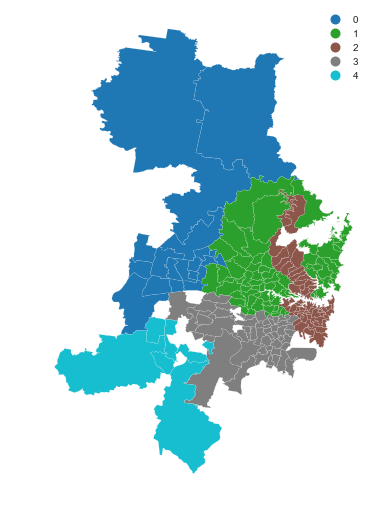

In [22]:
# Then plot the classes onto the map.
f, ax = plt.subplots(1, figsize=(9, 9))

pdb.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

The map above shows a clear pattern: there is a class at the core of the eastern district (number 3, in grey), then two other ones surrounding the core area (number 1 and 4, in green and light-blue, respectively), and two peripheral sets of areas (number 0 and 2, blue and brown).

This gives us a good insight into the geographical structure, but fail to analysis the elements inside groups. The next step is to explore how the proportion of different types of properties are distributed across clusters.

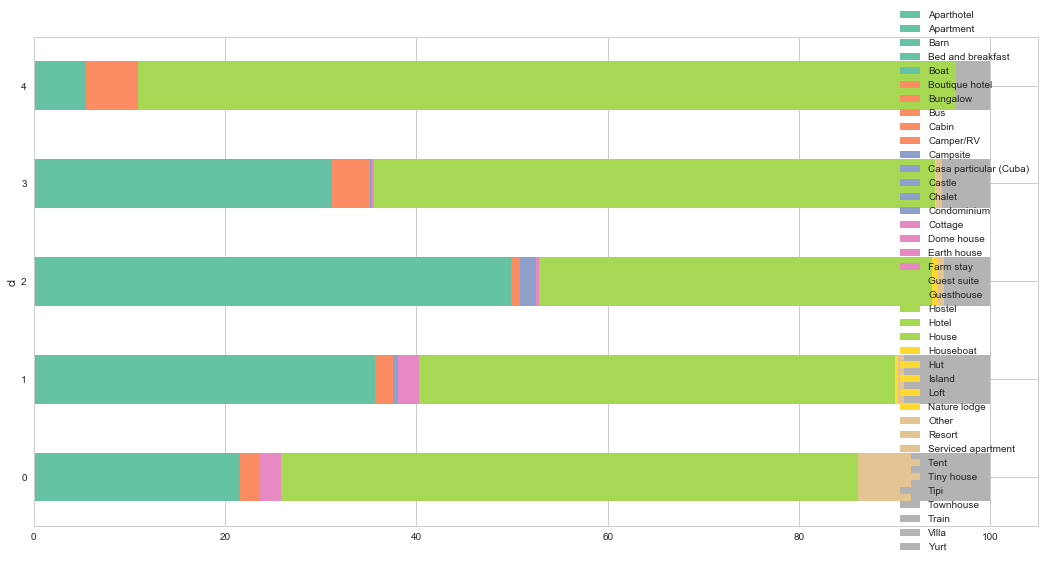

In [23]:
# Extract the properties and plot as a stack chart.
cl_pcts = prop_types_pct.reindex(pdb['postcode']).assign(cl=km5cls.labels_).groupby('cl').mean()

f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax,cmap='Set2', linewidth=0)

ax.legend(ncol=1, loc="right");

First, most of the locations we have in the dataset are either apartments or single-houses. However, how they are distributed depends on the location. The urban core -cluster 3- distinctively has the highest proportion of apartments and townhouses. The surrounding area -clusters 1 and 4- is very consistent, with a medium share of houses and apartments.The periphery area -cluster 0 and 2- are dominated by houses, suggesting there are not that many places listed at AirBnb.

# 4: Melbourn Clustering

In [24]:
# Aggregate data to regional level.
varis_m = ['bedrooms', 'bathrooms', 'beds']

#All of the variables are numerical values, so a quick way to aggregate them is by obtaining the average per postcode.
aves_m = Mel_lst.groupby('zipcode')[varis_m].mean()
aves_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471 entries, 2010.0 to VIC 3161
Data columns (total 3 columns):
bedrooms     471 non-null float64
bathrooms    471 non-null float64
beds         471 non-null float64
dtypes: float64(3)
memory usage: 14.7+ KB


In [25]:
# Extract housing type in Melbourn.
types_m = pd.get_dummies(Mel_lst['property_type'])
prop_types_m = types_m.join(Mel_lst['zipcode']).groupby('zipcode').sum()
prop_types_pct_m = (prop_types_m * 100.).div(prop_types_m.sum(axis=1), axis=0)
prop_types_pct_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471 entries, 2010.0 to VIC 3161
Data columns (total 38 columns):
Aparthotel                471 non-null float64
Apartment                 471 non-null float64
Barn                      471 non-null float64
Bed and breakfast         471 non-null float64
Boat                      471 non-null float64
Boutique hotel            471 non-null float64
Bungalow                  471 non-null float64
Cabin                     471 non-null float64
Camper/RV                 471 non-null float64
Campsite                  471 non-null float64
Casa particular (Cuba)    471 non-null float64
Castle                    471 non-null float64
Chalet                    471 non-null float64
Condominium               471 non-null float64
Cottage                   471 non-null float64
Earth house               471 non-null float64
Farm stay                 471 non-null float64
Guest suite               471 non-null float64
Guesthouse                471 non-null float

In [26]:
## Join the dataset together.

aves_props_m = aves_m.join(prop_types_pct_m)

# Change the columns
db_m = pd.DataFrame(scale(aves_props_m), index=aves_props_m.index, columns=aves_props_m.columns)

In [27]:
# Combines the postcode area and data.
pdb_m = pcm[['geometry', 'postcode']].join(db_m, on='postcode').dropna()

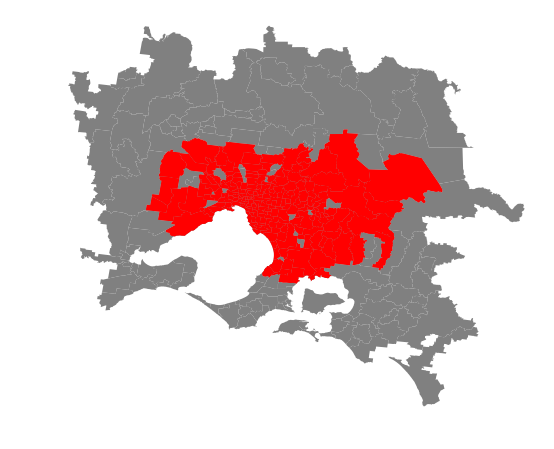

In [28]:
# Some of the area have lost in the process, plot the two area together to see the difference.
# The graph shows the most of the Airbnb listing is in central district.
f, ax = plt.subplots(1, figsize=(9, 9))

pcm.plot(color='grey', linewidth=0, ax=ax)
pdb_m.plot(color='red', linewidth=0.1, ax=ax)

ax.set_axis_off()

plt.show()

In [29]:
# Define 5 groups in KMeans calculation.
km5 = cluster.KMeans(n_clusters=5)

#Following the sklearn pipeline approach, the clustering happens when we fit the model to the data
km5cls_m = km5.fit(pdb_m.drop(['geometry'], axis=1).values)

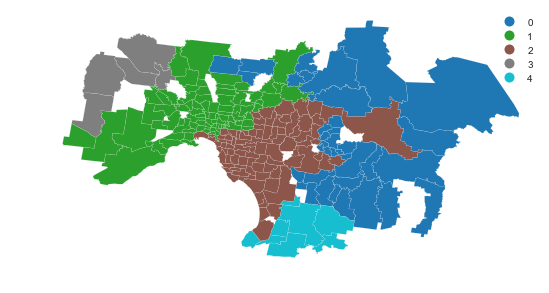

In [30]:
# Then plot the classes onto the map.
f, ax = plt.subplots(1, figsize=(9, 9))

pdb_m.assign(cl=km5cls_m.labels_).plot(column='cl', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

The map above shows a different pattern with Sydney: there are two class seperate the center of Melbourn (number 0 and 2, in blue and brown), then the rest classed set in the peripheral areas (number 1, 3 and 4, in green, grey and light-blue, respectively).

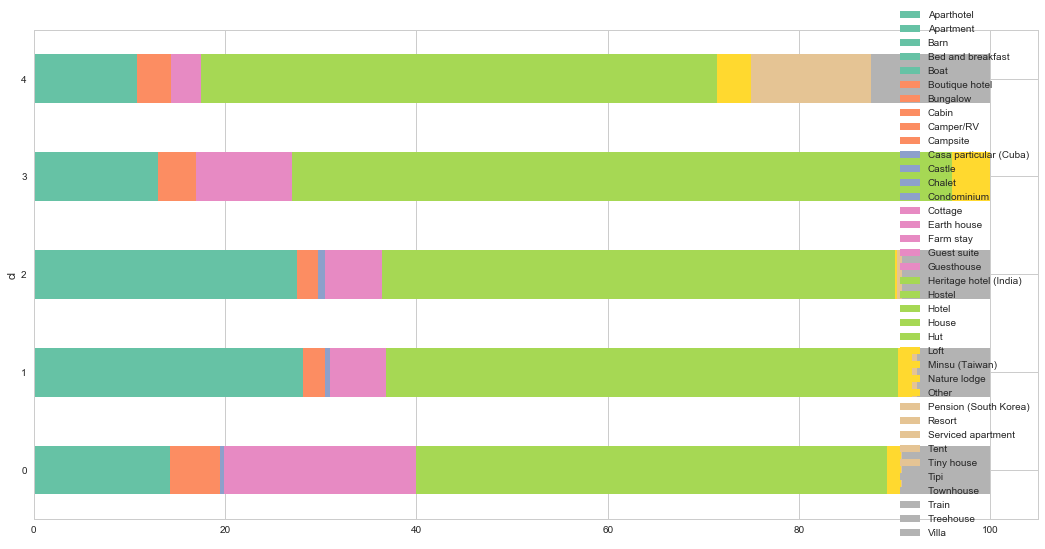

In [31]:
# Extract the properties and plot as a stack chart.
cl_pcts_m = prop_types_pct_m.reindex(pdb_m['postcode']).assign(cl=km5cls_m.labels_).groupby('cl').mean()

f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts_m.plot(kind='barh', stacked=True, ax=ax,cmap='Set2', linewidth=0)

ax.legend(ncol=1, loc="right");

First, most of the clusters we have in the dataset are either apartments or single-houses, but the single-house has a higher proportion in Melbourn than Sydney. However, the urban core -cluster 0 and 2- still has the highest proportion of apartments. The periphery area -clusters 1, 3 and 4- has different attributes. Cluster 1 has the largest proportion of Farm stay and earth house, means this area has more camping activities on the green land. The cluster 3 has the most tent and tiny house, the location overlapped with current tourist attractions, which suggest future investment in this area.

# 5: Reflection
In this study, KMeans clustering and Kernel Density Estimation has been applied in the process. In cluster analysis, the k-means algorithm can be used to partition the input data set into k clusters. However, the pure k-means algorithm is not very flexible, and as such is of limited use. In particular, the parameter k is known to be hard to choose when not given by external constraints, this study choose five clusters as a primary analysis, future analysis could focus on the refining of the cluster number. 

In addition, KDE is a alternative methods to visualise large number of points. Large number of listings are hard to recognize on the graph, in this case, an abstracted surface that models the probability of point density over space was a better method to mapping the listings. The key advandage of datashader library is that is decouples the point processing from the plotting. That is the bit that allows it to be scalable to truly large datasets (e.g. millions of points). Essentially, the approach is based on generating a very fine grid, counting points within pixels, and encoding the count into a color scheme. However, the attempt to overlap KDE result with map was failed, future work could also focus on creating a better graph to demonstrate KDE with its geographic location.

# 6:Conclusion
Airbnb involves renting an entire home, a room or a shared room for a short term with a higher prices. Short-term rental of an entire house or flat that is available all year is equivalent to reducing long-term rental options. Some research(Alizadeh, Farid and Sarkar, 2018) argues that Airbnb poses a possible threat to rental affordability. The income Airbnb generates in areas of cities popular with tourists causes owners of rental properties to withdraw these from the long-term rental market(Tomlinson, 2017). It also causes investors to acquire property and enter the Airbnb market, and to increase the cost of long-term rental.

This study explains the housing type clustering using current Airbnb listing data. The listing density in the central area has indicates that part of the housnig has been occupied with housing in dual living capabilities. That may stress the affordaility in the area which has a high proportion of Airbnb listing. The scale of Airbnb impacts on rents, displacement of long-term renters and neighbourhood fragmentation has led cities such as Barcelona, New York and Amsterdam to attempt to ban, or strictly regulate, the extent and location of Airbnb(Rawnsley, 2018). Adopting this policy may have a chance to reduce the presure on housing in these area.

# References

Alexander, J. (2016). How Airbnb is reshaping our cities. [online] The Conversation. Available at: https://theconversation.com/how-airbnb-is-reshaping-our-cities-63932 [Accessed 4 Nov. 2018].

Alizadeh, T. (2018). Airbnb: who's in, who's out, and what this tells us about rental impacts in Sydney and Melbourne. [online] The Conversation. Available at: https://theconversation.com/airbnb-whos-in-whos-out-and-what-this-tells-us-about-rental-impacts-in-sydney-and-melbourne-95865 [Accessed 4 Nov. 2018].

Alizadeh, T., Farid, R. and Sarkar, S. (2018). Towards Understanding the Socio-Economic Patterns of Sharing Economy in Australia: An Investigation of Airbnb Listings in Sydney and Melbourne Metropolitan Regions. Urban Policy and Research, pp.1-19.

Prd.com.au. (2018). Airbnb Changing Housing Affordability. [online] Available at: https://www.prd.com.au/corporate-news-page/article/airbnb-changing-housing-affordability/ [Accessed 4 Nov. 2018].

Rawnsley, T. (2018). What impact does Airbnb have on the Sydney and Melbourne housing markets? - SGS Economics & Planning. [online] Sgsep.com.au. Available at: https://www.sgsep.com.au/publications/what-impact-does-airbnb-have-sydney-and-melbourne-housing-markets [Accessed 4 Nov. 2018].

Tomlinson, R. (2017). Airbnb and empty houses: who's responsible for managing the impacts on our cities?. [online] The Conversation. Available at: https://theconversation.com/airbnb-and-empty-houses-whos-responsible-for-managing-the-impacts-on-our-cities-83959 [Accessed 4 Nov. 2018].